In [1]:
import numpy as np
import glob
import re
import matplotlib.pyplot as plt
from scipy.io import loadmat
import math
import h5py
import os.path
from catheter import preprocess_period, preprocess_length


# Period based data

/home/tingtaoz/storage/traindatalevy/allparams/0819/sample766_U020uf5.01823alpha1.5tauR2_11.5806_24.909_23.9723.h5


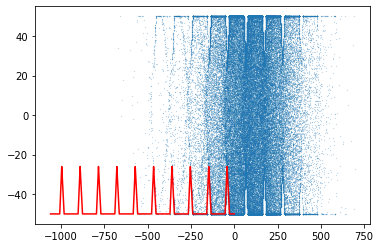

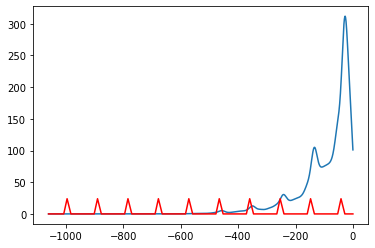

In [2]:
pref_folder = "/groups/esm/dzhuang/Catheter/allparam"
train_data_folder = "/home/tingtaoz/storage/traindatalevy/allparams/0819"
info_file = "/home/tingtaoz/storage/traindatalevy/allparams/0819/params.txt"

# Study the effect of bw_method
t = 9
ind = 5

data_info = np.genfromtxt(info_file, delimiter=',', skip_header=1)
file_names = glob.glob(train_data_folder+"/sample*")
file_name = file_names[ind]
print(file_name)
ncx1, ncx2, ncx3, ncx4 = 50, 50, 50, 50 
n_periods = 10
x_mesh, y_mesh, x_b, y_b, xx, density_1d_data,  my_data = preprocess_period(ind, t,  data_info, file_name, 
                                                                     ncx1=ncx1, ncx2=ncx2, ncx3=ncx3, ncx4=ncx4, n_periods=n_periods)

sample, uf, L_p, x1, x2, x3, h = my_data

plt.figure()
plt.scatter(x_b, y_b, s=0.01)
plt.plot(x_mesh, y_mesh - 50, color="red")

# density 
plt.figure()
plt.plot(xx,  density_1d_data)
plt.plot(x_mesh, y_mesh, color="red")

In [3]:
pref_folder = "/groups/esm/dzhuang/Catheter/allparam/period"
train_data_folder = "/home/tingtaoz/storage/traindatalevy/allparams/0819"
info_file = "/home/tingtaoz/storage/traindatalevy/allparams/0819/params.txt"
data_info = np.genfromtxt(info_file, delimiter=',', skip_header=1)
file_names = glob.glob(train_data_folder+"/sample*")

ncx1, ncx2, ncx3, ncx4 = 50, 50, 50, 50 
ncx = ncx1 + ncx2 + ncx3 + ncx4
n_periods = 10

n_data = len(file_names)
density_1d_data = np.zeros((n_periods*ncx+1, n_data))
x_mesh, y_mesh = np.zeros((n_periods*ncx+1, n_data)), np.zeros((n_periods*ncx+1, n_data))
data_info_all = np.zeros((7, n_data))
# change t
t = 9
file_names = glob.glob(train_data_folder+"/sample*")
for ind in range(n_data):
    file_name = file_names[ind]
    sample  = np.int64(  file_name[file_name.find("sample") + len("sample"):  file_name.find("_U")]  )
    uf  = np.float64(  file_name[file_name.find("uf") + len("uf"):  file_name.find("alpha")]  )
    # sample is from 1 - 1000
    n_ind = 3*(sample - 1) 
    if uf < (5.0 + 10.0)/2:
        n_ind += 0
    elif uf < (10. + 15.0)/2:
        n_ind += 1
    elif uf < (15. + 20.0)/2:
        n_ind += 2
    else:
        print("error! uf = ", uf)
        
    x_mesh[:,  n_ind], y_mesh[:,  n_ind], x_b, y_b, xx, density_1d_data[:,  n_ind],  data_info_all[:,  n_ind] = preprocess_period(ind, t,  data_info, file_name, 
                                                                     ncx1=ncx1, ncx2=ncx2, ncx3=ncx3, ncx4=ncx4, n_periods=n_periods)

np.save(pref_folder+"/density_1d_data.npy", density_1d_data)
np.save(pref_folder+"/x_1d_structured_mesh.npy",   x_mesh)
np.save(pref_folder+"/y_1d_structured_mesh.npy",   y_mesh)
np.save(pref_folder+"/data_info.npy",   data_info_all)

# Length based data

/home/tingtaoz/storage/traindatalevy/allparams/0819/sample848_U020uf10.0443alpha1.5tauR2_-0.542027_24.1627_22.0826.h5


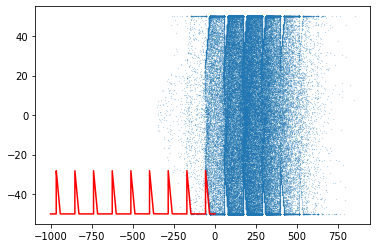

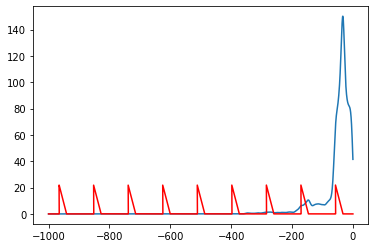

In [6]:
pref_folder = "/groups/esm/dzhuang/Catheter/allparam"
train_data_folder = "/home/tingtaoz/storage/traindatalevy/allparams/0819"
info_file = "/home/tingtaoz/storage/traindatalevy/allparams/0819/params.txt"
# Study the effect of bw_method
t = 9
ind = 10

data_info = np.genfromtxt(info_file, delimiter=',', skip_header=1)
file_names = glob.glob(train_data_folder+"/sample*")
file_name = file_names[ind]
print(file_name)
N_s, L_x = 2001, 1000
x_mesh, y_mesh, x_b, y_b, xx, density_1d_data,  my_data = preprocess_length(ind, t,  data_info, file_name, 
                                                                     N_s = N_s, L_x = L_x)

sample, uf, L_p, x1, x2, x3, h = my_data

plt.figure()
plt.scatter(x_b, y_b, s=0.01)
plt.plot(x_mesh, y_mesh - 50, color="red")

# density 
plt.figure()
plt.plot(xx,  density_1d_data)
plt.plot(x_mesh, y_mesh, color="red")

In [8]:
pref_folder = "/groups/esm/dzhuang/Catheter/allparam/length"
train_data_folder = "/home/tingtaoz/storage/traindatalevy/allparams/0819"
info_file = "/home/tingtaoz/storage/traindatalevy/allparams/0819/params.txt"
data_info = np.genfromtxt(info_file, delimiter=',', skip_header=1)
file_names = glob.glob(train_data_folder+"/sample*")

N_s, L_x = 2001, 1000

n_data = len(file_names)
density_1d_data = np.zeros((N_s, n_data))
x_mesh, y_mesh = np.zeros((N_s, n_data)), np.zeros((N_s, n_data))
data_info_all = np.zeros((7, n_data))
# change t
t = 9
file_names = glob.glob(train_data_folder+"/sample*")

for ind in range(n_data):
    file_name = file_names[ind]
    sample  = np.int64(  file_name[file_name.find("sample") + len("sample"):  file_name.find("_U")]  )
    uf  = np.float64(  file_name[file_name.find("uf") + len("uf"):  file_name.find("alpha")]  )
    # sample is from 1 - 1000
    n_ind = 3*(sample - 1) 
    if uf < (5.0 + 10.0)/2:
        n_ind += 0
    elif uf < (10. + 15.0)/2:
        n_ind += 1
    elif uf < (15. + 20.0)/2:
        n_ind += 2
    else:
        print("error! uf = ", uf)
        
    x_mesh[:,  n_ind], y_mesh[:,  n_ind], x_b, y_b, xx, density_1d_data[:,  n_ind],  data_info_all[:,  n_ind] = preprocess_length(ind, t,  data_info, file_name, 
                                                                     N_s = N_s, L_x = L_x)

np.save(pref_folder+"/density_1d_data.npy", density_1d_data)
np.save(pref_folder+"/x_1d_structured_mesh.npy",   x_mesh)
np.save(pref_folder+"/y_1d_structured_mesh.npy",   y_mesh)
np.save(pref_folder+"/data_info.npy",   data_info_all)

In [ ]:
"""
r: Zongyi Li and Daniel Zhengyu Huang
"""

import numpy
import torch.nn.functional as F
import matplotlib.pyplot as plt
from timeit import default_timer
from catheter import *
from utilities3 import *
from Adam import Adam

torch.manual_seed(0)
np.random.seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True


################################################################
# configs
################################################################
# load data
PATH = "/groups/esm/dzhuang/Catheter/allparam/"

INPUT_X = PATH+"x_1d_structured_mesh.npy"
INPUT_Y = PATH+"y_1d_structured_mesh.npy"
INPUT_para = PATH+"data_info.npy"
OUTPUT = PATH+"density_1d_data.npy"

ntrain = 2000
ntest = 1000

batch_size = 20
learning_rate = 0.001

epochs = 2 #501
step_size = 100
gamma = 0.5



n_periods = 4

modes = n_periods*16
width = n_periods*32
# nx ny
s = n_periods*200 + 1
s3 = n_periods*1000 + 1

################################################################
# load data and data normalization
################################################################
inputX = np.load(INPUT_X)
print("inputX.shape", inputX.shape)
inputX = torch.tensor(inputX, dtype=torch.float).permute(1,0)
inputY = np.load(INPUT_Y)
inputY = torch.tensor(inputY, dtype=torch.float).permute(1,0)

# setup inputZ
inputPara = np.load(INPUT_para)
n_features = 1
n_data, n_p = inputX.shape
inputZ = np.zeros((n_data, n_p, n_features))
for i in range(n_features):
    inputZ[:,:,i] = np.outer(inputPara[1, :], np.ones(n_p))
inputZ = torch.tensor(inputZ, dtype=torch.float)


input = torch.stack([inputX, inputY], dim=-1)
input = torch.cat([input, inputZ], dim=2)
print("n_data, n_p, n_features = ", input.shape)



output = np.load(OUTPUT)
output = torch.tensor(output, dtype=torch.float).permute(1,0)
print(input.shape, output.shape)

index = torch.randperm(ntrain+ntest)
train_index = index[:ntrain]
test_index = index[-ntest:]

x_train = input[train_index]
y_train = output[train_index]
x_test = input[test_index]
y_test = output[test_index]
x_train = x_train.reshape(ntrain, s, n_features+2)
x_test = x_test.reshape(ntest, s, n_features+2)

train_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(x_train, y_train), batch_size=batch_size,
                                           shuffle=True)
test_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(x_test, y_test), batch_size=batch_size,
                                          shuffle=False)
test_loader2 = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(x_test, y_test), batch_size=1,
                                          shuffle=False)

if __name__ == "__main__":
    ################################################################
    # training and evaluation
    ################################################################
    model = FNO1d(modes, width).cuda()
    print(count_params(model))

    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)

    myloss = LpLoss(size_average=False)

    for ep in range(epochs):
        model.train()
        t1 = default_timer()
        train_l2 = 0
        for x, y in train_loader:
            x, y = x.cuda(), y.cuda()

            optimizer.zero_grad()
            out = model(x)
            
            print("x = ", x.shape, torch.sum(x))
            print("out = ", out.shape, torch.sum(out))
            print("y = ", y.shape, torch.sum(y))
            
            loss = myloss(out.view(batch_size, -1), y.view(batch_size, -1))
            loss.backward()
            
            print(num_examples)
            num_examples = out.view(batch_size, -1).size()[0]
            diff_norms = torch.norm(out.view(batch_size, -1).reshape(num_examples, -1), 2, 1)
            y_norms = torch.norm(y.view(batch_size, -1).reshape(num_examples, -1), 2, 1)
            print(diff_norms, y_norms)
            print("loss = ", loss.item())

            optimizer.step()
            train_l2 += loss.item()

        scheduler.step()

        model.eval()
        test_l2 = 0.0
        with torch.no_grad():
            for x, y in test_loader:
                x, y = x.cuda(), y.cuda()

                out = model(x)
                test_l2 += myloss(out.view(batch_size, -1), y.view(batch_size, -1)).item()

        train_l2 /= ntrain
        test_l2 /= ntest

        t2 = default_timer()
        print(ep, t2 - t1, train_l2, test_l2)

        # plot
        if ep%step_size==0:
            torch.save(model, 'catheter_plain_model_1d'+str(ep))



In [ ]:
torch.sum(output, axis=1).shape
print(torch.argmin(torch.sum(output, axis=1)))
plt.plot(torch.sum(output, axis=1))


In [26]:
inputZ

tensor([[[15.0434],
         [15.0434],
         [15.0434],
         ...,
         [15.0434],
         [15.0434],
         [15.0434]],

        [[ 0.0000],
         [ 0.0000],
         [ 0.0000],
         ...,
         [ 0.0000],
         [ 0.0000],
         [ 0.0000]],

        [[15.0422],
         [15.0422],
         [15.0422],
         ...,
         [15.0422],
         [15.0422],
         [15.0422]],

        ...,

        [[ 7.5219],
         [ 7.5219],
         [ 7.5219],
         ...,
         [ 7.5219],
         [ 7.5219],
         [ 7.5219]],

        [[ 7.5201],
         [ 7.5201],
         [ 7.5201],
         ...,
         [ 7.5201],
         [ 7.5201],
         [ 7.5201]],

        [[ 0.0000],
         [ 0.0000],
         [ 0.0000],
         ...,
         [ 0.0000],
         [ 0.0000],
         [ 0.0000]]])